In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Import Data

In [2]:
np.random.seed(7)

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Data/Data%20TMA%20(Daily%202022-2025).csv')
data = data.loc[:, ['Daily_Period','TMA_Daily']]
data = data.iloc[:1216].reset_index(drop=True)

print(data.head())
print(data.tail())
print(data.shape)

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1211   26/04/2025  20.000000
1212   27/04/2025  20.000000
1213   28/04/2025  21.666667
1214   29/04/2025  20.000000
1215   30/04/2025  14.166667
(1216, 2)


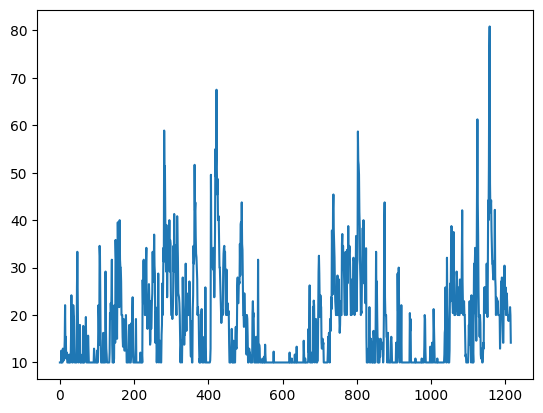

In [4]:
plt.plot(data['TMA_Daily'])

# Normalisasi Data

Proses normalisasi data dilakukan menggunakan metode min-max normalization hingga menghasilkan data yang berskala [0,1].

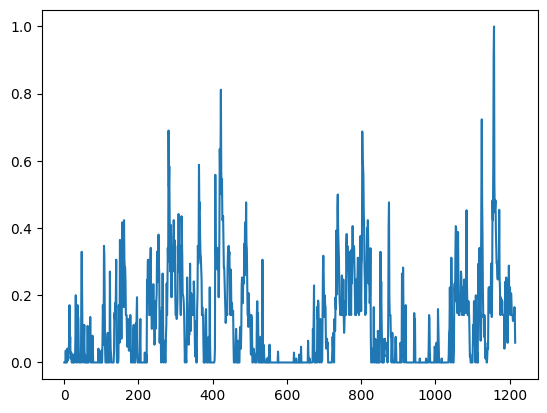

In [5]:
# Step 1: Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['TMA_normalized'] = scaler.fit_transform(data['TMA_Daily'].values.reshape(-1, 1))
plt.plot(data['TMA_normalized'])

# Hyperparameter Tuning & Cross Validation

Hyperparameter tuning dilakukan untuk menentukan hyperparameter terbaik melalui langkah validasi berupa *time series k-fold cross validation*. Banyaknya fold yang digunakan dalam langkah validasi adalah sebanyak k = 5.

EXPANDING WINDOW

In [6]:
data_series = data['TMA_normalized'].values
data_series = data_series.reshape((len(data_series), 1))
data_series

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.16470588],
       [0.14117647],
       [0.05882353]])

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def create_model(neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(30, 1), return_sequences=True))
    model.add(LSTM(16))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [8]:
import keras

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # print('abcd')
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

## Sliding Window Cross Validation

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0156 - val_loss: 0.0254
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0055 - val_loss: 0.0279
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0102 - val_loss: 0.0186
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0046 - val_loss: 0.0192
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0050 - val_loss: 0.0111
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0049 - val_loss: 0.0237
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0041 - val_loss: 0.0213
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0038 - val_loss: 0.0172
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0029 - val_loss: 0.0136
Epoch 10/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0041 - val_loss: 0.0165
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0308 - val_loss: 0.0370
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0150 - val_loss: 0.0446
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0138 - val_loss: 0.0218
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0087 - val_loss: 0.0200
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0148 - val_loss: 0.0279
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0113 - val_loss: 0.0190
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0082 - val_loss: 0.0222
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0101 - val_loss: 0.0260
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0092 - val_loss: 0.0177
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0117 - val_loss: 0.0288
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0117 - val_loss: 0.0269
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0070 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0039 - val_loss: 2.6589e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0035 - val_loss: 6.7759e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0020 - val_loss: 1.4938e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0016 - val_loss: 2.1651e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 9.8978e-04 - val_loss: 0.0024
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0020 - val_loss: 1.4747e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0022 - val_loss: 2.1864e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.7925e-04 - val_loss: 3.6137e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0021 - val_loss: 1.6748e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0015 - val_loss: 2.0457e-04
Epoch 11/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019Restoring model weights from the end of the best e

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0289 - val_loss: 0.0111
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0123 - val_loss: 0.0067
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0112 - val_loss: 0.0029
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0079 - val_loss: 0.0035
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0103 - val_loss: 0.0050
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 8/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0166Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0164 - val_loss: 0.0046
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 15.430809074726154 %
mape test = 11.188797466028827 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0192 - val_loss: 0.0219
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0101 - val_loss: 0.0211
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0135 - val_loss: 0.0183
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0075 - val_loss: 0.0126
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0075 - val_loss: 0.0109
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0054 - val_loss: 0.0125
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0066 - val_loss: 0.0138
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0065 - val_loss: 0.0125
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0057 - val_loss: 0.0132
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0047 - val_loss: 0.0195
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

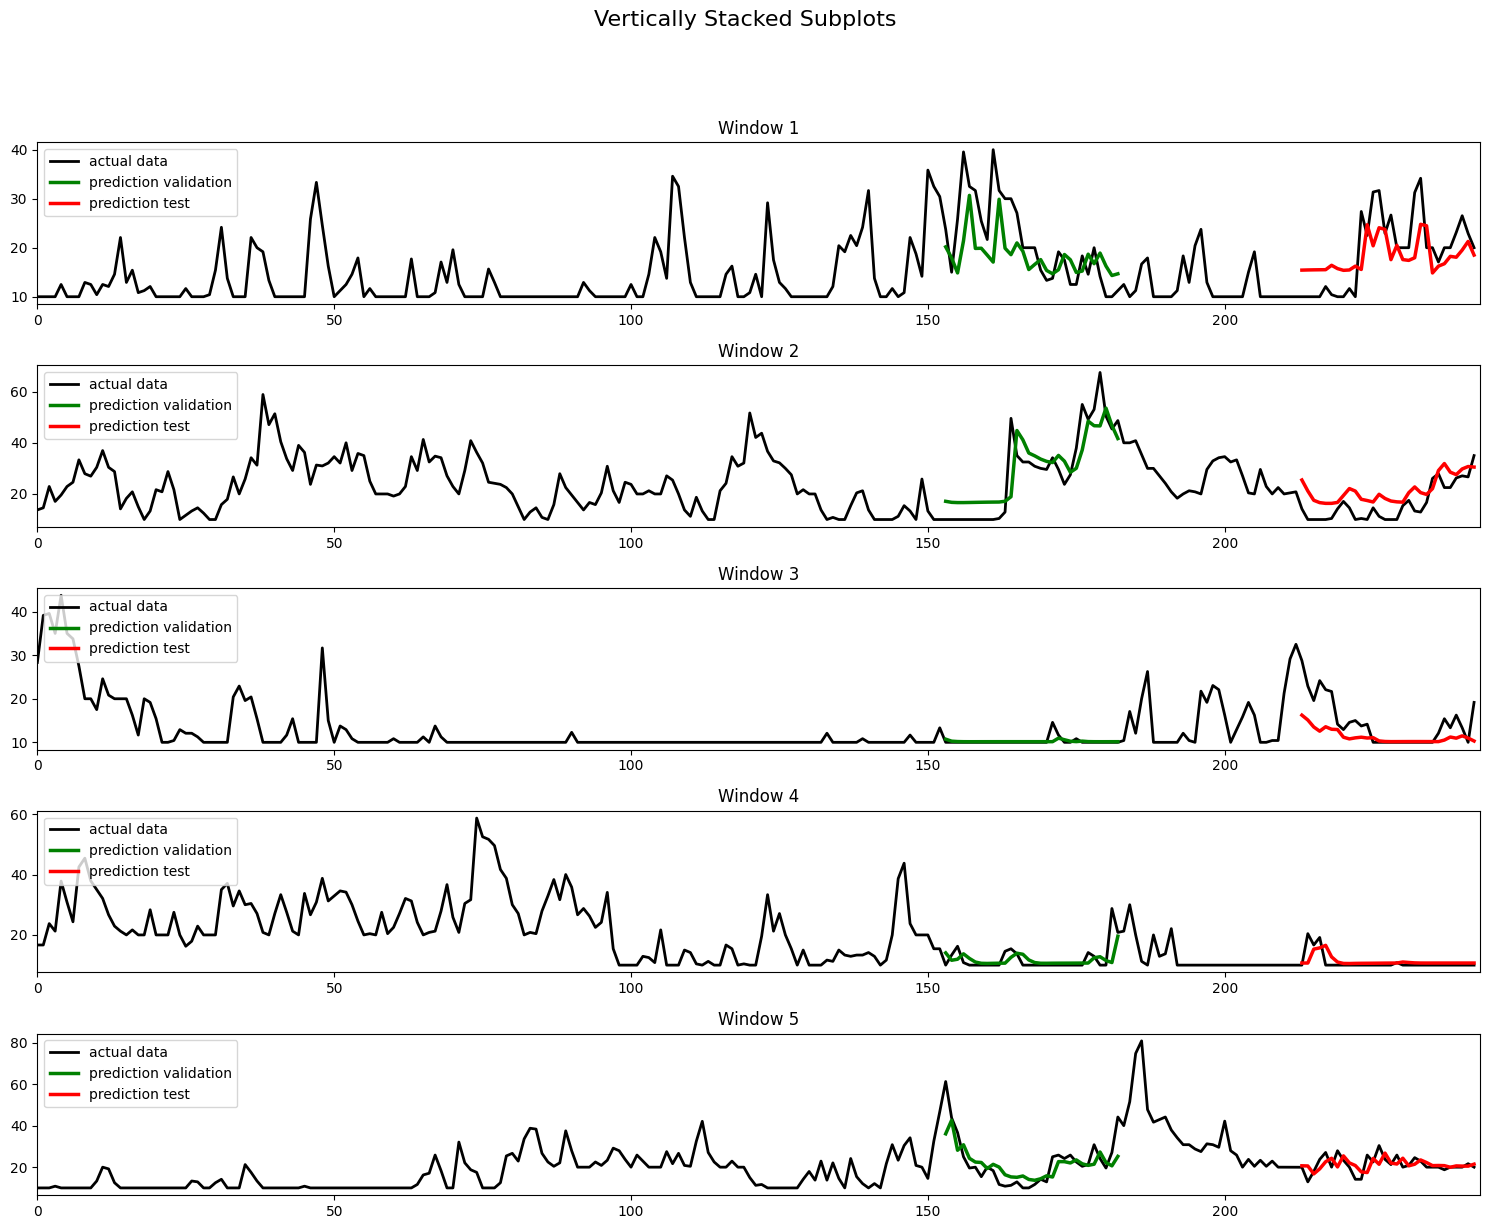


Final Average MAPE Validation: 0.2054
Final Average MAPE Test: 0.2420
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0130 - val_loss: 0.0194
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0045 - val_loss: 0.0322
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0057 - val_loss: 0.0160
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0053 - val_loss: 0.0169
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0044 - val_loss: 0.0249
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0037 - val_loss: 0.0268
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0088 - val_loss: 0.0161
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0053 - val_loss: 0.0152
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0047 - val_loss: 0.0177
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0050 - val_loss: 0.0144
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0037 - val_loss: 0.0225
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0027 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0512 - val_loss: 0.0485
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0183 - val_loss: 0.0239
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0138 - val_loss: 0.0221
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0095 - val_loss: 0.0222
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0093 - val_loss: 0.0208
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0158 - val_loss: 0.0251
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0120 - val_loss: 0.0173
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0124 - val_loss: 0.0171
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0094 - val_loss: 0.0242
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0112 - val_loss: 0.0184
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0078 - val_loss: 0.0170
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0090 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0018 - val_loss: 1.9261e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0021 - val_loss: 2.8694e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0019 - val_loss: 4.1883e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0018 - val_loss: 9.3532e-04
Epoch 6/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0019 - val_loss: 2.1251e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
mape validation = 7.390912464694393 %
mape test = 22.19087046905786 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0249 - val_loss: 0.0107
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0154 - val_loss: 0.0037
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0139 - val_loss: 0.0168
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0107 - val_loss: 0.0041
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0095 - val_loss: 0.0031
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0074 - val_loss: 0.0031
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0087 - val_loss: 0.0141
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0123Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0156 - val_loss: 0.0243
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0109 - val_loss: 0.0198
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0084 - val_loss: 0.0144
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0064 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0058 - val_loss: 0.0142
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0051 - val_loss: 0.0133
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0044 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0056 - val_loss: 0.0130
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0056 - val_loss: 0.0127
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0070 - val_loss: 0.0115
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0074 - val_loss: 0.0118
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0073 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1920
Final Average MAPE Test: 0.2243
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0082 - val_loss: 0.0292
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0083 - val_loss: 0.0312
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0063 - val_loss: 0.0122
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0039 - val_loss: 0.0156
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0057 - val_loss: 0.0130
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0067 - val_loss: 0.0165
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0023 - val_loss: 0.0136
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0047 - val_loss: 0.0112
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0092 - val_loss: 0.0133
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0062 - val_loss: 0.0261
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0026 - val_loss: 0.0137
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0035 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0372 - val_loss: 0.0367
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0157 - val_loss: 0.0239
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0091 - val_loss: 0.0322
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0107 - val_loss: 0.0216
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0102 - val_loss: 0.0195
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0091 - val_loss: 0.0206
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0083 - val_loss: 0.0317
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0109 - val_loss: 0.0219
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0067 - val_loss: 0.0203
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0104 - val_loss: 0.0286
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0096 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0030 - val_loss: 1.5076e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0040 - val_loss: 6.2722e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0022 - val_loss: 1.4934e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0050 - val_loss: 1.9626e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0015 - val_loss: 4.6152e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0013 - val_loss: 9.6587e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0020 - val_loss: 6.7526e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0025Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0025 - val_loss: 2.0791e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 3.7381578697448035 %
mape test = 22.137020982870283 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0257 - val_loss: 0.0076
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0144 - val_loss: 0.0110
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0155 - val_loss: 0.0085
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0132 - val_loss: 0.0034
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0094 - val_loss: 0.0037
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0097 - val_loss: 0.0038
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0104Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0103 - val_loss: 0.0054
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 26.049416863

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0175 - val_loss: 0.0205
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0084 - val_loss: 0.0174
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0068 - val_loss: 0.0152
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0074 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0054 - val_loss: 0.0253
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0074 - val_loss: 0.0145
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0057 - val_loss: 0.0151
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0074 - val_loss: 0.0126
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0074Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0074 - val_loss: 0.0117
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 23.994210597

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2008
Final Average MAPE Test: 0.2384
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0074 - val_loss: 0.0250
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0070 - val_loss: 0.0287
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0090 - val_loss: 0.0151
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0045 - val_loss: 0.0122
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0031 - val_loss: 0.0164
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0041 - val_loss: 0.0100
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0052 - val_loss: 0.0108
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0050 - val_loss: 0.0114
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0093 - val_loss: 0.0188
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0046 - val_loss: 0.0170
Epoch 11/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0031Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0187 - val_loss: 0.0456
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0181 - val_loss: 0.0237
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0117 - val_loss: 0.0237
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0117 - val_loss: 0.0301
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0145 - val_loss: 0.0223
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0087 - val_loss: 0.0192
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0088 - val_loss: 0.0214
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0153 - val_loss: 0.0185
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0161 - val_loss: 0.0182
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0119 - val_loss: 0.0247
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0093 - val_loss: 0.0184
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0132 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0044 - val_loss: 1.6487e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0028 - val_loss: 5.2002e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0024 - val_loss: 1.7758e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 2.3610e-04
Epoch 6/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0030 - val_loss: 2.4595e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 5.812330746927852 %
mape test = 22.96150759604482 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0345 - val_loss: 0.0393
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0185 - val_loss: 0.0052
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0130 - val_loss: 0.0115
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0082 - val_loss: 0.0035
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0156 - val_loss: 0.0127
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0097Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0097 - val_loss: 0.0039
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 15.595569127

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0171 - val_loss: 0.0213
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0100 - val_loss: 0.0196
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0077 - val_loss: 0.0137
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0057 - val_loss: 0.0142
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0074 - val_loss: 0.0108
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0040 - val_loss: 0.0122
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0061 - val_loss: 0.0112
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0069 - val_loss: 0.0110
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0083 - val_loss: 0.0148
Epoch 10/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0059Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0059 - val_loss: 0.0132
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2010
Final Average MAPE Test: 0.2326
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0496 - val_loss: 0.0208
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0130 - val_loss: 0.0295
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0078 - val_loss: 0.0250
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0193 - val_loss: 0.0325
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0079 - val_loss: 0.0233
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0185Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0184 - val_loss: 0.0461
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 31.27184545616774 %
mape test = 38.155866279742575 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0577 - val_loss: 0.0599
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0199 - val_loss: 0.0833
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0475 - val_loss: 0.0581
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0271 - val_loss: 0.0580
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0315 - val_loss: 0.0660
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0276 - val_loss: 0.0587
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0215 - val_loss: 0.0581
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0257 - val_loss: 0.0621
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0264Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0264 - val_loss: 0.0633
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
mape validation = 83.73678908

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0335 - val_loss: 1.6487e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0012 - val_loss: 2.6591e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0028 - val_loss: 3.8512e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0012 - val_loss: 3.2781e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 2.0522751364958323 %
mape test = 23.47968543698751 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.1306 - val_loss: 0.0930
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0203 - val_loss: 0.0321
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0220 - val_loss: 0.0321
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0271 - val_loss: 0.0443
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0228 - val_loss: 0.0279
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0248 - val_loss: 0.0132
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0239 - val_loss: 0.0036
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0402 - val_loss: 0.0534
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0288 - val_loss: 0.0939
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0309 - val_loss: 0.0630
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0249 - val_loss: 0.0735
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0357Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0346 - val_loss: 0.0285
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0156 - val_loss: 0.0362
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0138 - val_loss: 0.0354
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0182 - val_loss: 0.0322
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0151 - val_loss: 0.0584
Epoch 6/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0178Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0178 - val_loss: 0.0285
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 36.570034124058665 %
mape test = 15.797218325769949 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.3642
Final Average MAPE Test: 0.4469
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0331 - val_loss: 0.0326
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0057 - val_loss: 0.0331
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0104 - val_loss: 0.0216
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0107 - val_loss: 0.0342
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0079 - val_loss: 0.0510
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0071 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0120 - val_loss: 0.0352
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0041 - val_loss: 0.0110
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0073 - val_loss: 0.0180
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0084 - val_loss: 0.0148
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0091 - val_loss: 0.0164
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0078 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0580 - val_loss: 0.0591
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0209 - val_loss: 0.0621
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0226 - val_loss: 0.0581
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0255 - val_loss: 0.0614
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0236 - val_loss: 0.0629
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0243 - val_loss: 0.0635
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0202 - val_loss: 0.0711
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0223Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0223 - val_loss: 0.0608
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 84.12024303655315 %
mape test = 113.61756947442791 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014 - val_loss: 2.5868e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0016 - val_loss: 2.0424e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0039 - val_loss: 1.5585e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0031 - val_loss: 4.2832e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0037Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0037 - val_loss: 1.5778e-04
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape vali

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1446 - val_loss: 0.0317
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0245 - val_loss: 0.0383
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0245 - val_loss: 0.0400
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0226 - val_loss: 0.0406
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0253 - val_loss: 0.0683
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0290Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0290 - val_loss: 0.0551
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
mape validation = 114.10232080664622 %
mape test = 127.98770537134669 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0381 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0157 - val_loss: 0.0321
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0156 - val_loss: 0.0383
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0148 - val_loss: 0.0273
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0125 - val_loss: 0.0390
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0157 - val_loss: 0.0260
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0155 - val_loss: 0.0266
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0159 - val_loss: 0.0443
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0201 - val_loss: 0.0263
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0147 - val_loss: 0.0273
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0160Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/ste

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.5343
Final Average MAPE Test: 0.6137
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0565 - val_loss: 0.0240
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0063 - val_loss: 0.0191
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0078 - val_loss: 0.0284
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0039 - val_loss: 0.0269
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0057 - val_loss: 0.0228
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0042 - val_loss: 0.0335
Epoch 7/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0062Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0062 - val_loss: 0.0300
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 31.45856421630307 %
mape test = 38.404180789295786 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1711 - val_loss: 0.0556
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0211 - val_loss: 0.0887
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0247 - val_loss: 0.0520
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0249 - val_loss: 0.0582
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0219 - val_loss: 0.0551
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0242 - val_loss: 0.0567
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0239 - val_loss: 0.0561
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0250Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0250 - val_loss: 0.0579
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 76.58017380771906 %
mape test = 99.67294747427525 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0393 - val_loss: 5.1291e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 8.7789e-04 - val_loss: 0.0034
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0043 - val_loss: 5.6323e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0022 - val_loss: 2.1755e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 2.5858e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0039Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape valid

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1424 - val_loss: 0.0151
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0279 - val_loss: 0.0758
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0272 - val_loss: 0.0377
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0288 - val_loss: 0.0364
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0243 - val_loss: 0.0260
Epoch 6/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0309Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0308 - val_loss: 0.0277
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 77.9495026888748 %
mape test = 88.0894763360892 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.1970 - val_loss: 0.0311
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0154 - val_loss: 0.0522
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0155 - val_loss: 0.0340
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0119 - val_loss: 0.0382
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0188 - val_loss: 0.0275
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0159 - val_loss: 0.0311
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0113 - val_loss: 0.0310
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0155 - val_loss: 0.0303
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0139 - val_loss: 0.0262
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0134 - val_loss: 0.0329
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0151 - val_loss: 0.0276
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0136 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.4707
Final Average MAPE Test: 0.5225
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0165 - val_loss: 0.0277
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0071 - val_loss: 0.0386
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0065 - val_loss: 0.0176
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0072 - val_loss: 0.0144
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0090 - val_loss: 0.0320
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0067 - val_loss: 0.0361
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0099 - val_loss: 0.0216
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0059 - val_loss: 0.0211
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0055 - val_loss: 0.0268
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 33.886578068

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.1335 - val_loss: 0.0582
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0355 - val_loss: 0.0601
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0342 - val_loss: 0.0603
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0281 - val_loss: 0.0583
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0319 - val_loss: 0.0595
Epoch 6/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0193Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0194 - val_loss: 0.0623
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 81.08498320445203 %
mape test = 104.73606043027677 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0252 - val_loss: 0.0019
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0045 - val_loss: 3.5739e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0025 - val_loss: 1.9629e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0017 - val_loss: 9.2190e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0031 - val_loss: 5.4151e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0019 - val_loss: 5.0359e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0028 - val_loss: 7.3776e-04
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0023Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0023 - val_loss: 3.7005e-04
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
ma

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0917 - val_loss: 0.0204
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0269 - val_loss: 0.0139
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0171 - val_loss: 0.0281
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0184 - val_loss: 0.0200
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0122 - val_loss: 0.0052
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0090 - val_loss: 0.0039
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0154 - val_loss: 0.0369
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0458 - val_loss: 0.1676
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0299 - val_loss: 0.0962
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0415 - val_loss: 0.0050
Epoch 11/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0319Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0613 - val_loss: 0.0263
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0135 - val_loss: 0.0261
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0152 - val_loss: 0.0458
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0171 - val_loss: 0.0394
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0162 - val_loss: 0.0304
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0122 - val_loss: 0.0381
Epoch 7/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0187Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0187 - val_loss: 0.0269
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 44.104229325441324 %
mape test = 17.641768714246002 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.3700
Final Average MAPE Test: 0.4098
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0058 - val_loss: 0.0197
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0068 - val_loss: 0.0255
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0060 - val_loss: 0.0253
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0063 - val_loss: 0.0270
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0052 - val_loss: 0.0278
Epoch 7/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0060 - val_loss: 0.0246
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 28.914249354773077 %
mape test = 33.37630851968421 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0396 - val_loss: 0.0453
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0209 - val_loss: 0.0375
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0137 - val_loss: 0.0363
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0135 - val_loss: 0.0352
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0166 - val_loss: 0.0310
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0134 - val_loss: 0.0273
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0121 - val_loss: 0.0249
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0109 - val_loss: 0.0232
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0110 - val_loss: 0.0224
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0088 - val_loss: 0.0208
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0090 - val_loss: 0.0219
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0108 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0027 - val_loss: 3.8368e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0019 - val_loss: 4.6349e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0024 - val_loss: 2.0917e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0017 - val_loss: 3.9757e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0015 - val_loss: 2.2139e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0065 - val_loss: 1.5302e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0024 - val_loss: 1.8268e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0027 - val_loss: 1.9339e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0016 - val_loss: 1.9631e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0020 - val_loss: 1.8950e-04
Epoch 11/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0012Restoring model weights from the end of the best epoch

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0212 - val_loss: 0.0152
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0167 - val_loss: 0.0106
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0175 - val_loss: 0.0076
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0130 - val_loss: 0.0067
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0178 - val_loss: 0.0073
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0139 - val_loss: 0.0101
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0168 - val_loss: 0.0065
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0122 - val_loss: 0.0053
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0136 - val_loss: 0.0069
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0112 - val_loss: 0.0043
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0120 - val_loss: 0.0042
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0119 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0103 - val_loss: 0.0288
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0115 - val_loss: 0.0281
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0072 - val_loss: 0.0287
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0064 - val_loss: 0.0272
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0100 - val_loss: 0.0253
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0081 - val_loss: 0.0271
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0103 - val_loss: 0.0255
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0092 - val_loss: 0.0222
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0054 - val_loss: 0.0203
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0095 - val_loss: 0.0196
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0067 - val_loss: 0.0195
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0054 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2296
Final Average MAPE Test: 0.2620
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0071 - val_loss: 0.0250
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0070 - val_loss: 0.0213
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0049 - val_loss: 0.0294
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0043 - val_loss: 0.0215
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0058 - val_loss: 0.0262
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0034 - val_loss: 0.0217
Epoch 7/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0041 - val_loss: 0.0231
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 29.848048468432868 %
mape test = 34.35061572920137 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0291 - val_loss: 0.0496
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0193 - val_loss: 0.0319
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0204 - val_loss: 0.0491
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0140 - val_loss: 0.0350
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0175 - val_loss: 0.0340
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0125 - val_loss: 0.0314
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0122 - val_loss: 0.0247
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0154 - val_loss: 0.0269
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0127 - val_loss: 0.0217
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0149 - val_loss: 0.0229
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0105 - val_loss: 0.0201
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0086 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0025 - val_loss: 2.2496e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0025 - val_loss: 1.5552e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.4553e-04 - val_loss: 2.3209e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0010 - val_loss: 8.2033e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0023 - val_loss: 1.4913e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0015 - val_loss: 1.9744e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0018 - val_loss: 1.5922e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.0152e-04 - val_loss: 6.3961e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0019 - val_loss: 1.5222e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0012 - val_loss: 2.5968e-04
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0307 - val_loss: 0.0154
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0149 - val_loss: 0.0103
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0195 - val_loss: 0.0063
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0126 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0171 - val_loss: 0.0052
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0172 - val_loss: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0102 - val_loss: 0.0112
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0202 - val_loss: 0.0041
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0151 - val_loss: 0.0043
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0112 - val_loss: 0.0039
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0152 - val_loss: 0.0038
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0115 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0105 - val_loss: 0.0307
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0073 - val_loss: 0.0293
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0097 - val_loss: 0.0279
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0095 - val_loss: 0.0269
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0090 - val_loss: 0.0251
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0044 - val_loss: 0.0275
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0101 - val_loss: 0.0237
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0075 - val_loss: 0.0237
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0082 - val_loss: 0.0204
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0098 - val_loss: 0.0190
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0078 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2374
Final Average MAPE Test: 0.2626
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0078 - val_loss: 0.0206
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0061 - val_loss: 0.0222
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0061 - val_loss: 0.0210
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0049 - val_loss: 0.0176
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0050 - val_loss: 0.0229
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0041 - val_loss: 0.0221
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0043 - val_loss: 0.0216
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0072 - val_loss: 0.0220
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0054Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0054 - val_loss: 0.0245
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 27.843984830

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0332 - val_loss: 0.0479
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0186 - val_loss: 0.0419
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0175 - val_loss: 0.0373
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0175 - val_loss: 0.0306
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0142 - val_loss: 0.0366
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0100 - val_loss: 0.0270
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0142 - val_loss: 0.0241
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0136 - val_loss: 0.0256
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0096 - val_loss: 0.0223
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0103 - val_loss: 0.0230
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0088 - val_loss: 0.0207
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0077 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0021 - val_loss: 2.4344e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0034 - val_loss: 3.2504e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0034 - val_loss: 2.6901e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0017 - val_loss: 1.6633e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0020 - val_loss: 2.3490e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0022 - val_loss: 1.5294e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0031 - val_loss: 1.6011e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0012 - val_loss: 1.5190e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0016 - val_loss: 2.3374e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0012 - val_loss: 1.5098e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0021 - val_loss: 1.7507e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0296 - val_loss: 0.0096
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0154 - val_loss: 0.0089
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0154 - val_loss: 0.0077
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0155 - val_loss: 0.0083
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0123 - val_loss: 0.0098
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0108 - val_loss: 0.0055
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0175 - val_loss: 0.0048
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0089 - val_loss: 0.0067
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0099 - val_loss: 0.0046
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0110 - val_loss: 0.0041
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0086 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0072 - val_loss: 0.0294
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0076 - val_loss: 0.0284
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0076 - val_loss: 0.0279
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0083 - val_loss: 0.0265
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0094 - val_loss: 0.0247
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0055 - val_loss: 0.0240
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0075 - val_loss: 0.0256
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0105 - val_loss: 0.0217
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0076 - val_loss: 0.0218
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0086 - val_loss: 0.0203
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0059 - val_loss: 0.0208
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0072 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2196
Final Average MAPE Test: 0.2479
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0122 - val_loss: 0.0404
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0050 - val_loss: 0.0216
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0052 - val_loss: 0.0272
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0056 - val_loss: 0.0189
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0047 - val_loss: 0.0238
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0070 - val_loss: 0.0226
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0057 - val_loss: 0.0249
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0041 - val_loss: 0.0223
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0044Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0044 - val_loss: 0.0210
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 28.487137168

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0213 - val_loss: 0.0400
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0178 - val_loss: 0.0438
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0188 - val_loss: 0.0385
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0172 - val_loss: 0.0311
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0158 - val_loss: 0.0381
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0150 - val_loss: 0.0303
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0126 - val_loss: 0.0244
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0120 - val_loss: 0.0220
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0101 - val_loss: 0.0237
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0106 - val_loss: 0.0198
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0095 - val_loss: 0.0209
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0121 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0022 - val_loss: 7.1544e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0018 - val_loss: 1.5448e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0015 - val_loss: 1.5637e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0033 - val_loss: 1.6299e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0017 - val_loss: 1.5626e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0015 - val_loss: 9.6131e-04
Epoch 7/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0012Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0012 - val_loss: 2.3371e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 4.014850654910245 %
mape test = 24.043233119918163 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0375 - val_loss: 0.0048
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0184 - val_loss: 0.0156
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0174 - val_loss: 0.0102
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0149 - val_loss: 0.0086
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0169 - val_loss: 0.0101
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0181Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0180 - val_loss: 0.0076
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 34.47607268415742 %
mape test = 32.20386150009145 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0145 - val_loss: 0.0321
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0081 - val_loss: 0.0284
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0077 - val_loss: 0.0289
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0092 - val_loss: 0.0253
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0083 - val_loss: 0.0244
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0078 - val_loss: 0.0237
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0083 - val_loss: 0.0214
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0085 - val_loss: 0.0221
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0083 - val_loss: 0.0211
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0077 - val_loss: 0.0199
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0078 - val_loss: 0.0191
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0088 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2566
Final Average MAPE Test: 0.3028
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0068 - val_loss: 0.0266
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0036 - val_loss: 0.0219
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0047 - val_loss: 0.0197
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0044 - val_loss: 0.0207
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0052 - val_loss: 0.0116
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0055 - val_loss: 0.0158
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0047 - val_loss: 0.0219
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0054 - val_loss: 0.0146
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0037 - val_loss: 0.0144
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0043Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0283 - val_loss: 0.0336
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0153 - val_loss: 0.0269
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0122 - val_loss: 0.0216
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0138 - val_loss: 0.0215
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0113 - val_loss: 0.0222
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0079 - val_loss: 0.0201
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0074 - val_loss: 0.0215
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0126 - val_loss: 0.0218
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0086 - val_loss: 0.0233
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0081 - val_loss: 0.0211
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0105 - val_loss: 0.0197
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0115 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0036 - val_loss: 1.6979e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0024 - val_loss: 2.6830e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0018 - val_loss: 1.5118e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0012 - val_loss: 4.7290e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0025 - val_loss: 1.9040e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0026 - val_loss: 1.8575e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0021 - val_loss: 1.5333e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0025Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0025 - val_loss: 1.8553e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 3.1766937025732163 %
mape test = 22.454178292699435 %
Epoch 1/50

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0275 - val_loss: 0.0061
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0124 - val_loss: 0.0201
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0143 - val_loss: 0.0049
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0203 - val_loss: 0.0034
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0126 - val_loss: 0.0033
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0073 - val_loss: 0.0109
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0089 - val_loss: 0.0032
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0129 - val_loss: 0.0032
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0061 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0151 - val_loss: 0.0252
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0068 - val_loss: 0.0187
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0061 - val_loss: 0.0197
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0100 - val_loss: 0.0161
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0068 - val_loss: 0.0131
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0060 - val_loss: 0.0121
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0083 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0049 - val_loss: 0.0154
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0102 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1860
Final Average MAPE Test: 0.2114
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0059 - val_loss: 0.0302
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0058 - val_loss: 0.0176
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0057 - val_loss: 0.0411
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0047 - val_loss: 0.0180
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0041 - val_loss: 0.0217
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0045 - val_loss: 0.0211
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0055 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0034 - val_loss: 0.0145
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0063 - val_loss: 0.0209
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0027 - val_loss: 0.0132
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0048 - val_loss: 0.0153
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0350 - val_loss: 0.0387
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0238 - val_loss: 0.0324
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0133 - val_loss: 0.0338
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0141 - val_loss: 0.0249
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0109 - val_loss: 0.0222
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0120 - val_loss: 0.0211
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0111 - val_loss: 0.0189
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0105 - val_loss: 0.0188
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0069 - val_loss: 0.0207
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0089 - val_loss: 0.0212
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0113 - val_loss: 0.0182
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0108 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0021 - val_loss: 1.7357e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0014 - val_loss: 5.9750e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0013 - val_loss: 1.5542e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 1.5505e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015 - val_loss: 1.5418e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0021 - val_loss: 1.9160e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0013 - val_loss: 1.6927e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0015 - val_loss: 1.6981e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0011 - val_loss: 1.8517e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0013 - val_loss: 1.5280e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0018 - val_loss: 1.9393e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0147 - val_loss: 0.0055
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0221 - val_loss: 0.0036
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0114 - val_loss: 0.0033
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0082 - val_loss: 0.0049
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0081 - val_loss: 0.0054
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0085 - val_loss: 0.0032
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0067 - val_loss: 0.0076
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0138 - val_loss: 0.0038
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0098 - val_loss: 0.0033
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0090 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0091 - val_loss: 0.0385
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0103 - val_loss: 0.0213
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0094 - val_loss: 0.0195
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0075 - val_loss: 0.0161
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0064 - val_loss: 0.0140
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0065 - val_loss: 0.0124
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0064 - val_loss: 0.0145
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0043 - val_loss: 0.0154
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0074 - val_loss: 0.0114
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0059 - val_loss: 0.0126
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0060 - val_loss: 0.0105
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0048 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1947
Final Average MAPE Test: 0.2194
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0084 - val_loss: 0.0173
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0089 - val_loss: 0.0187
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0048 - val_loss: 0.0266
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0038 - val_loss: 0.0104
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0037 - val_loss: 0.0170
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0039 - val_loss: 0.0178
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0049 - val_loss: 0.0132
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0036 - val_loss: 0.0157
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0031 - val_loss: 0.0162
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 22.429338108

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0298 - val_loss: 0.0458
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0158 - val_loss: 0.0231
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0115 - val_loss: 0.0254
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0141 - val_loss: 0.0254
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0087 - val_loss: 0.0193
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0092 - val_loss: 0.0194
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0092 - val_loss: 0.0188
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0085 - val_loss: 0.0205
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0126 - val_loss: 0.0290
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0098 - val_loss: 0.0188
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0065 - val_loss: 0.0213
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0132Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0018 - val_loss: 3.4956e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0011 - val_loss: 1.5364e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0016 - val_loss: 7.2955e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0017 - val_loss: 3.3256e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0026 - val_loss: 2.9588e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0020 - val_loss: 2.2608e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0017 - val_loss: 1.5357e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0012 - val_loss: 1.5094e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0021 - val_loss: 2.2918e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0032 - val_loss: 3.7507e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 8.8374e-04 - val_loss: 3.1590e-04
Epoch 12/50
93/93 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0156 - val_loss: 0.0087
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0108 - val_loss: 0.0032
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0134 - val_loss: 0.0034
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0165 - val_loss: 0.0032
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0108 - val_loss: 0.0089
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 7/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0063Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
mape validation = 16.33561856482646 %
mape test = 10.69909846288241 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0113 - val_loss: 0.0236
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0108 - val_loss: 0.0219
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0108 - val_loss: 0.0172
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0091 - val_loss: 0.0145
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0083 - val_loss: 0.0116
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0044 - val_loss: 0.0110
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0059 - val_loss: 0.0112
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0078 - val_loss: 0.0104
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0058 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0059 - val_loss: 0.0138
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0071 - val_loss: 0.0115
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0058 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2181
Final Average MAPE Test: 0.2600
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0076 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0058 - val_loss: 0.0216
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0095 - val_loss: 0.0259
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0058 - val_loss: 0.0169
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0061 - val_loss: 0.0272
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0059 - val_loss: 0.0162
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0041 - val_loss: 0.0191
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0038 - val_loss: 0.0117
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0057 - val_loss: 0.0165
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0017 - val_loss: 0.0134
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0026 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0058 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0244 - val_loss: 0.0537
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0126 - val_loss: 0.0259
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0173 - val_loss: 0.0204
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0088 - val_loss: 0.0229
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0082 - val_loss: 0.0190
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0100 - val_loss: 0.0301
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0095 - val_loss: 0.0228
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0094 - val_loss: 0.0174
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0071 - val_loss: 0.0223
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0079 - val_loss: 0.0184
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0074 - val_loss: 0.0188
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0131 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0088 - val_loss: 1.6556e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0019 - val_loss: 1.5152e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0019 - val_loss: 1.6418e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0024 - val_loss: 2.2908e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0022 - val_loss: 1.9804e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0025 - val_loss: 5.6470e-04
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0016 - val_loss: 2.7563e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
mape validation = 3.1817740444305764 %
mape test = 21.07428777697264 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0228 - val_loss: 0.0062
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0124 - val_loss: 0.0166
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0125 - val_loss: 0.0050
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0083 - val_loss: 0.0182
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0111 - val_loss: 0.0060
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0123 - val_loss: 0.0049
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0091 - val_loss: 0.0041
Epoch 11/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0062Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0117 - val_loss: 0.0220
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0079 - val_loss: 0.0189
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0093 - val_loss: 0.0171
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0072 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0082 - val_loss: 0.0129
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0040 - val_loss: 0.0121
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0053 - val_loss: 0.0126
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0038 - val_loss: 0.0115
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0078 - val_loss: 0.0132
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0063 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0063Restorin

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1958
Final Average MAPE Test: 0.2228


In [10]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, figsize=(15, 12))
fig.suptitle('Vertically Stacked Subplots', fontsize=16, y=1.02)

# Parameter Sliding Window Cross Validation
window_size = 243        # Train Window
n_test = 60              # Test Window
n_train_and_val = window_size - n_test
n_train = n_train_and_val - 60
shift = 243
n_windows1 = 5
n_total = len(data_series)
look_back = 30
time_step = 30

import itertools

config_params = {
    "learning_rate" : [0.01, 0.05, 0.001, 0.005],
    "batch_size" : [16, 32, 64, 128],
    "neurons" : [50],
}

average_mape_vals_by_param = []
average_mape_tests_by_param = []

for xs in itertools.product(*list(config_params.values())):
  current_param = dict()
  for i, key in enumerate(config_params.keys()):
    if key == "batch_size":
      bsize = xs[i]
    else:
      current_param[key] = xs[i]

  mape_vals = []
  mape_tests = []

  for i in range(n_windows1):
      start = i * shift
      end = start + window_size
      if end > n_total:
          print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
          break

      window_data = data_series[start:end] #sliding window
      train_and_val = window_data[:n_train_and_val]
      train = train_and_val[:n_train]
      val = train_and_val[n_train:]
      test = window_data[n_train_and_val:]

      try:

          train_generator = TimeseriesGenerator(train, train, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          val_generator = TimeseriesGenerator(val, val, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          test_generator = TimeseriesGenerator(test, test, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          model = create_model(current_param['neurons'], current_param['learning_rate'])

          # model.compile(optimizer='adam', loss='mean_squared_error')

          model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=bsize, callbacks=[EarlyStoppingAtMinLoss(patience=5)], verbose = 1)

          val_predictions = model.predict(val_generator)
          test_predictions  = model.predict(test_generator)

          val_predictions_descale = scaler.inverse_transform(val_predictions).flatten()
          test_predictions_descale = scaler.inverse_transform(test_predictions).flatten()

          train_actual = scaler.inverse_transform(train).flatten()
          val_actual = scaler.inverse_transform(val).flatten()
          test_actual = scaler.inverse_transform(test).flatten()

          all_actual = np.append(np.append(train_actual, val_actual), test_actual)

          mape_val = mean_absolute_percentage_error(val_actual[-len(val_generator):], val_predictions_descale)
          mape_test = mean_absolute_percentage_error(test_actual[-len(test_generator):], test_predictions_descale)

          mape_vals.append(mape_val)
          mape_tests.append(mape_test)

          print(f"mape validation = {mape_val * 100} %")
          print(f"mape test = {mape_test * 100} %")

          X_actual = np.arange(0, len(train) + len(val) + len(test))
          # X_train = np.arange(0, len(train))
          X_val = np.arange(len(train) + look_back, len(train) + len(val))
          X_test = np.arange(len(train) + len(val) + look_back, len(train) + len(val) + len(test))

          axs[i].plot(X_actual, all_actual, lw=2, color='black', label='actual data')
          axs[i].plot(X_val, val_predictions_descale, lw=2.5, color='green', label='prediction validation')
          axs[i].plot(X_test, test_predictions_descale, lw=2.5, color='red', label='prediction test')
          axs[i].set_xlim([0, len(all_actual)])
          axs[i].set_title(f'Window {i+1}')
          axs[i].legend(loc='upper left')  # legend untuk setiap subplot

      except Exception as e:
          print(f"Error pada Window {i+1}: {e}")
          continue

  # Setelah loop selesai semua
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

  # Rata-rata MAPE akhir
  if mape_vals and mape_tests:
      final_mape_val = np.mean(mape_vals)
      final_mape_test = np.mean(mape_tests)
      print(f"\nFinal Average MAPE Validation: {final_mape_val:.4f}")
      print(f"Final Average MAPE Test: {final_mape_test:.4f}")
      average_mape_vals_by_param.append(final_mape_val)
      average_mape_tests_by_param.append(final_mape_test)

### Hyperparameter Summary (SWCV)

In [12]:
hyperparameter_summary = pd.DataFrame({
    "mape_vals" : average_mape_vals_by_param,
    "mape_tests" : average_mape_tests_by_param
})


hyperparameter_summary.sort_values("mape_tests")

,mape_vals,mape_tests
12,0.186032,0.211355
13,0.194707,0.219444
15,0.195836,0.222827
1,0.191983,0.224276
3,0.201017,0.232626
2,0.200764,0.238364
0,0.205445,0.241967
10,0.219601,0.247902
14,0.218140,0.260034
8,0.229620,0.262005


In [14]:
best_idx = int(hyperparameter_summary.sort_values("mape_tests").index[0])
best_idx

12

In [16]:
parameter_combinations = list(itertools.product(*list(config_params.values())))
best_parameter = parameter_combinations[best_idx]
best_param = dict()
for i, key in enumerate(config_params.keys()):
  best_param[key] = best_parameter[i]
best_param

{'learning_rate': 0.005, 'batch_size': 16, 'neurons': 50}

### Best Parameter (SWCV)

In [17]:
best_param = {'learning_rate': 0.005, 'batch_size': 16, 'neurons': 50}

In [18]:
def create_model(neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [19]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 900
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = create_model(best_param['neurons'], best_param['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0240 - val_loss: 0.0127
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0086 - val_loss: 0.0096
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0063 - val_loss: 0.0075
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 13/50

### Plot Model Loss

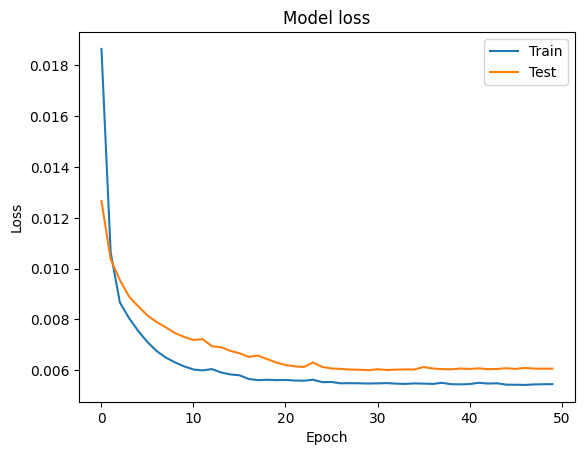

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Expanding Window Cross Validation

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0067 - val_loss: 0.0125
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0063 - val_loss: 0.0126
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0142
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 0.0142
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0034 - val_loss: 0.0134
Epoch 6/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0031 - val_loss: 0.0133
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 26.09646025800275 %
mape test = 29.90292888864559 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0047 - val_loss: 0.0189
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - val_loss: 0.0156
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0138
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0186
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0048 - val_loss: 0.0104
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0028 - val_loss: 0.0126
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - val_loss: 0.0114
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 0.0138
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - val_loss: 0.0103
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0110
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0112 - val_loss: 0.0285
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - val_loss: 0.0230
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046 - val_loss: 0.0127
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0051 - val_loss: 0.0130
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0120
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0041 - val_loss: 0.0080
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0043 - val_loss: 0.0083
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 0.0084
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0094
Epoch 11/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0062 - val_loss: 0.0184
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0057 - val_loss: 0.0109
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0061 - val_loss: 0.0126
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - val_loss: 0.0102
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - val_loss: 0.0117
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.0106
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.0080
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 0.0147
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0034 - val_loss: 0.0135
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0045 - val_loss: 0.0150
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0100
Epoch 12/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0079 - val_loss: 0.0170
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0078 - val_loss: 0.0125
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 0.0099
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - val_loss: 0.0180
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - val_loss: 0.0132
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0062 - val_loss: 0.0148
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0062 - val_loss: 0.0172
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 10/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - val_loss: 0.0117
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

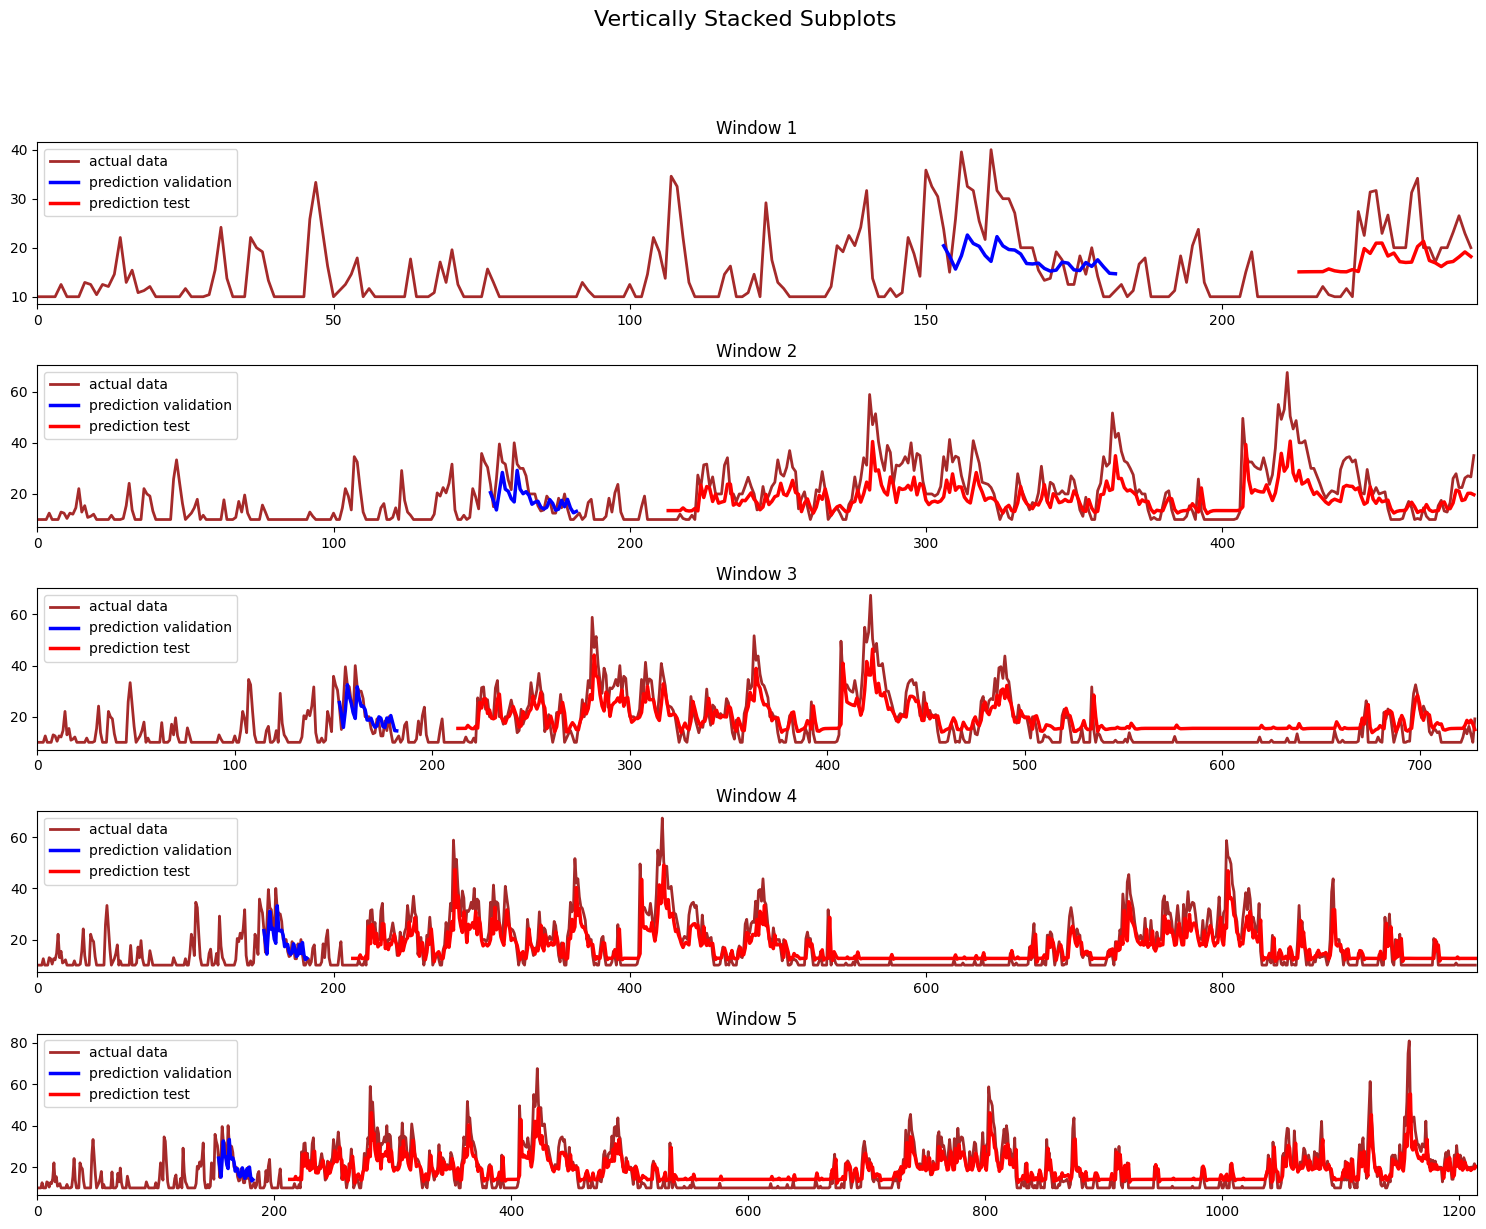


Final Average MAPE Validation: 0.2243
Final Average MAPE Test: 0.2831
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0121
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0094
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0035 - val_loss: 0.0174
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0061 - val_loss: 0.0194
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0046 - val_loss: 0.0112
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - val_loss: 0.0154
Epoch 8/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 0.0165
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 20.0899297049672 %
mape test = 23.378811876878512 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0087 - val_loss: 0.0181
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 0.0109
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 0.0123
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0115
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0046 - val_loss: 0.0137
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0025 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0035 - val_loss: 0.0229
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
mape validation = 22.208817913318356 %
mape test = 26.23092148893337 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0103 - val_loss: 0.0184
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0150
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0039 - val_loss: 0.0181
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0051 - val_loss: 0.0116
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0046 - val_loss: 0.0128
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 0.0113
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - val_loss: 0.0105
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0042 - val_loss: 0.0108
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.0120
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 0.0122
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0051 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0051 - val_loss: 0.0179
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0048 - val_loss: 0.0126
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0062 - val_loss: 0.0141
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 0.0096
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 0.0115
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0044 - val_loss: 0.0120
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0069 - val_loss: 0.0110
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0037 - val_loss: 0.0221
Epoch 10/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0071Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0070 - val_loss: 0.0199
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0051 - val_loss: 0.0125
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061 - val_loss: 0.0148
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0045 - val_loss: 0.0139
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0031 - val_loss: 0.0150
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 0.0200
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - val_loss: 0.0172
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
mape validation = 26.33618330067912 %
mape test = 35.271559490839124 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2285
Final Average MAPE Test: 0.2935
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0061 - val_loss: 0.0223
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053 - val_loss: 0.0143
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0037 - val_loss: 0.0183
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0097
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0035 - val_loss: 0.0174
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0032 - val_loss: 0.0076
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0188
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 0.0124
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0045 - val_loss: 0.0184
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0053 - val_loss: 0.0252
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0028 - val_loss: 0.0129
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0036 - val_loss: 0.0131
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0113
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0042 - val_loss: 0.0196
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0036 - val_loss: 0.0154
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0064 - val_loss: 0.0144
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052 - val_loss: 0.0135
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - val_loss: 0.0119
Epoch 12/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0075 - val_loss: 0.0172
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0043 - val_loss: 0.0127
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0031 - val_loss: 0.0092
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0042 - val_loss: 0.0180
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0036 - val_loss: 0.0131
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - val_loss: 0.0170
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0031 - val_loss: 0.0093
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0041 - val_loss: 0.0176
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
mape validation = 22.669728716766322 %
mape test = 30.5658942350642 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0046 - val_loss: 0.0169
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0067 - val_loss: 0.0180
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0028 - val_loss: 0.0096
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0063 - val_loss: 0.0192
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0033 - val_loss: 0.0075
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0028 - val_loss: 0.0080
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0039 - val_loss: 0.0145
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0033 - val_loss: 0.0152
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0039 - val_loss: 0.0151
Epoch 10/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0064 - val_loss: 0.0115
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0078 - val_loss: 0.0223
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0091 - val_loss: 0.0344
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0043 - val_loss: 0.0120
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0046 - val_loss: 0.0077
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0041 - val_loss: 0.0140
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032 - val_loss: 0.0107
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0040 - val_loss: 0.0121
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0030 - val_loss: 0.0106
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
mape validation = 21.01386

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2148
Final Average MAPE Test: 0.2706
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0085 - val_loss: 0.0176
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0030 - val_loss: 0.0131
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0070 - val_loss: 0.0103
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053 - val_loss: 0.0137
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0037 - val_loss: 0.0111
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0033 - val_loss: 0.0094
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0015 - val_loss: 0.0130
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0066 - val_loss: 0.0118
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0036 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0069 - val_loss: 0.0145
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0027 - val_loss: 0.0223
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0031 - val_loss: 0.0082
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0043 - val_loss: 0.0088
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0033 - val_loss: 0.0154
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0035 - val_loss: 0.0129
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027 - val_loss: 0.0080
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0048 - val_loss: 0.0079
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0039 - val_loss: 0.0124
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0045 - val_loss: 0.0115
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0057 - val_loss: 0.0170
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0062 - val_loss: 0.0241
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0031 - val_loss: 0.0105
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0040 - val_loss: 0.0135
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0027 - val_loss: 0.0085
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 0.0204
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0066 - val_loss: 0.0127
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035 - val_loss: 0.0157
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0043 - val_loss: 0.0133
Epoch 9/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0155
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
mape validation = 21.2226452

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0064 - val_loss: 0.0172
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0134
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0145
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0086 - val_loss: 0.0175
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0047 - val_loss: 0.0126
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0039 - val_loss: 0.0098
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044 - val_loss: 0.0080
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0039 - val_loss: 0.0096
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 12/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0059 - val_loss: 0.0140
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0054 - val_loss: 0.0148
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0039 - val_loss: 0.0119
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0043 - val_loss: 0.0156
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0027 - val_loss: 0.0112
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0046 - val_loss: 0.0175
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - val_loss: 0.0106
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044 - val_loss: 0.0137
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0032 - val_loss: 0.0114
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0036 - val_loss: 0.0119
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0099
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2108
Final Average MAPE Test: 0.2512
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0551 - val_loss: 0.0169
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0237 - val_loss: 0.0220
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0199 - val_loss: 0.0359
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0198 - val_loss: 0.0719
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0350 - val_loss: 0.0577
Epoch 6/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0451Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0448 - val_loss: 0.0429
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
mape validation = 49.859286425653174 %
mape test = 60.698272040862534 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0362 - val_loss: 0.0150
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0047 - val_loss: 0.0301
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0100 - val_loss: 0.0207
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - val_loss: 0.0141
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_loss: 0.0155
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0121
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0068 - val_loss: 0.0143
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0085 - val_loss: 0.0122
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0136
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0267 - val_loss: 0.0269
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0064 - val_loss: 0.0201
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0069 - val_loss: 0.0267
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0075 - val_loss: 0.0144
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0059 - val_loss: 0.0205
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - val_loss: 0.0118
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0101 - val_loss: 0.0172
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0037 - val_loss: 0.0179
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0036 - val_loss: 0.0144
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0090 - val_loss: 0.0211
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - val_loss: 0.0091
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0048 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0153 - val_loss: 0.0215
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0064 - val_loss: 0.0112
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0031 - val_loss: 0.0208
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0111
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0110
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0075 - val_loss: 0.0132
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0079 - val_loss: 0.0200
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0055 - val_loss: 0.0106
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0055 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0545 - val_loss: 0.0138
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0045 - val_loss: 0.0109
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0062 - val_loss: 0.0106
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0116 - val_loss: 0.0073
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0059 - val_loss: 0.0161
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0052 - val_loss: 0.0126
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047 - val_loss: 0.0205
Epoch 10/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0033 - val_loss: 0.0192
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2951
Final Average MAPE Test: 0.3590
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1378 - val_loss: 0.0270
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0096 - val_loss: 0.0393
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0106 - val_loss: 0.0185
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0079 - val_loss: 0.0230
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0088 - val_loss: 0.0174
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0218 - val_loss: 0.0485
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0230Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0228 - val_loss: 0.0225
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
mape validation = 37.365430065

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0615 - val_loss: 0.0860
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0249 - val_loss: 0.0250
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0180 - val_loss: 0.0553
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0198 - val_loss: 0.0178
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0261 - val_loss: 0.0268
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0328
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0118 - val_loss: 0.0088
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0032 - val_loss: 0.0101
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0041 - val_loss: 0.0163
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0088 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0285 - val_loss: 0.0283
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0081 - val_loss: 0.0144
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0056 - val_loss: 0.0086
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0099 - val_loss: 0.0169
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0033 - val_loss: 0.0225
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0088 - val_loss: 0.0128
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0139
Epoch 8/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - val_loss: 0.0246
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
mape validation = 29.545648181866213 %
mape test = 37.061017584711564 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0239 - val_loss: 0.0474
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0131 - val_loss: 0.0490
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0148 - val_loss: 0.0620
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0066 - val_loss: 0.0284
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0081 - val_loss: 0.0275
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0063 - val_loss: 0.0244
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032 - val_loss: 0.0078
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0034 - val_loss: 0.0115
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0083 - val_loss: 0.0191
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0056 - val_loss: 0.0110
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0861 - val_loss: 0.0155
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0255 - val_loss: 0.0876
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0276 - val_loss: 0.0185
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0236 - val_loss: 0.0196
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0150 - val_loss: 0.0520
Epoch 6/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0194Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0197 - val_loss: 0.1572
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
mape validation = 32.42382338981884 %
mape test = 49.16630365927861 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2882
Final Average MAPE Test: 0.3714
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0277 - val_loss: 0.0261
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0122 - val_loss: 0.0609
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0086 - val_loss: 0.0522
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0152 - val_loss: 0.0395
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0095 - val_loss: 0.0270
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058 - val_loss: 0.0182
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0070 - val_loss: 0.0087
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0068 - val_loss: 0.0201
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0048 - val_loss: 0.0090
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_loss: 0.0120
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0765 - val_loss: 0.0184
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0052 - val_loss: 0.0103
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0092 - val_loss: 0.0210
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0040 - val_loss: 0.0096
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044 - val_loss: 0.0182
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0050 - val_loss: 0.0118
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0056 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2196 - val_loss: 0.0178
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0068 - val_loss: 0.0157
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_loss: 0.0079
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0088 - val_loss: 0.0124
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0037 - val_loss: 0.0096
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0038 - val_loss: 0.0159
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - val_loss: 0.0380
Epoch 8/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0105Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0104 - val_loss: 0.0183
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
mape validation = 26.19263362275014 %
mape test = 42.11809380968899 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0111 - val_loss: 0.0297
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_loss: 0.0219
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0128 - val_loss: 0.0201
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0063 - val_loss: 0.0199
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0056 - val_loss: 0.0194
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0043 - val_loss: 0.0090
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0060 - val_loss: 0.0085
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058 - val_loss: 0.0171
Epoch 12/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0782 - val_loss: 0.0525
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0152 - val_loss: 0.0319
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0106 - val_loss: 0.0144
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0170 - val_loss: 0.0319
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0053 - val_loss: 0.0525
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0137 - val_loss: 0.0810
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0183 - val_loss: 0.0239
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0117 - val_loss: 0.0292
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0092 - val_loss: 0.0099
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0084 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2567
Final Average MAPE Test: 0.3311
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0633 - val_loss: 0.0203
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0071 - val_loss: 0.0129
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0053 - val_loss: 0.0199
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0057 - val_loss: 0.0252
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0070 - val_loss: 0.0108
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060 - val_loss: 0.0173
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0112
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0064 - val_loss: 0.0156
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045 - val_loss: 0.0175
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0064 - val_loss: 0.0097
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0049 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0197 - val_loss: 0.0102
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - val_loss: 0.0331
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0079 - val_loss: 0.0105
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058 - val_loss: 0.0213
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - val_loss: 0.0084
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0060 - val_loss: 0.0107
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0082 - val_loss: 0.0137
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0054 - val_loss: 0.0156
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028 - val_loss: 0.0184
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0084 - val_loss: 0.0167
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0691 - val_loss: 0.0200
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0210 - val_loss: 0.0829
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0238 - val_loss: 0.0289
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0234 - val_loss: 0.0131
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0164 - val_loss: 0.0539
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0100 - val_loss: 0.0651
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0101 - val_loss: 0.0181
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0074 - val_loss: 0.0141
Epoch 10/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0088 - val_loss: 0.0116
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0059 - val_loss: 0.0141
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0056 - val_loss: 0.0170
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0033 - val_loss: 0.0138
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0099
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0074 - val_loss: 0.0233
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - val_loss: 0.0091
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0075 - val_loss: 0.0251
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0044 - val_loss: 0.0087
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0053 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0369 - val_loss: 0.0143
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0092 - val_loss: 0.0299
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0074 - val_loss: 0.0144
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0052 - val_loss: 0.0177
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0040 - val_loss: 0.0216
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0067 - val_loss: 0.0135
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - val_loss: 0.0193
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0041 - val_loss: 0.0118
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056 - val_loss: 0.0178
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0075 - val_loss: 0.0212
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0058 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2680
Final Average MAPE Test: 0.3606
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0038 - val_loss: 0.0202
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0057 - val_loss: 0.0183
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0041 - val_loss: 0.0144
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0192
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0048 - val_loss: 0.0133
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054 - val_loss: 0.0175
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0046 - val_loss: 0.0180
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - val_loss: 0.0144
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0042 - val_loss: 0.0162
Epoch 10/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0037 - val_loss: 0.0180
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0067 - val_loss: 0.0204
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035 - val_loss: 0.0169
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0049 - val_loss: 0.0216
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0059 - val_loss: 0.0196
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0163
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0046 - val_loss: 0.0195
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0035 - val_loss: 0.0203
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0063 - val_loss: 0.0180
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0049 - val_loss: 0.0174
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - val_loss: 0.0144
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0045 - val_loss: 0.0174
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0040 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0067 - val_loss: 0.0255
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0038 - val_loss: 0.0220
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0185
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0169
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0053 - val_loss: 0.0174
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0032 - val_loss: 0.0129
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050 - val_loss: 0.0217
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 0.0194
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0041 - val_loss: 0.0185
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0156
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0056 - val_loss: 0.0211
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0038 - val_loss: 0.0151
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057 - val_loss: 0.0212
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0060 - val_loss: 0.0160
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0058 - val_loss: 0.0237
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0052 - val_loss: 0.0167
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0066 - val_loss: 0.0156
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
759/759 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
mape validation = 26.809217383931372 %
mape test = 33.22302548408517 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0071 - val_loss: 0.0248
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0034 - val_loss: 0.0154
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0159
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0046 - val_loss: 0.0181
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0053 - val_loss: 0.0250
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0057 - val_loss: 0.0200
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0143
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0151
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044 - val_loss: 0.0139
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0167
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0046 - val_loss: 0.0205
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0046 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2314
Final Average MAPE Test: 0.2741
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0072 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045 - val_loss: 0.0219
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032 - val_loss: 0.0143
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0055 - val_loss: 0.0185
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064 - val_loss: 0.0210
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0048 - val_loss: 0.0290
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0057 - val_loss: 0.0130
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045 - val_loss: 0.0200
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0040 - val_loss: 0.0165
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0040 - val_loss: 0.0179
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - val_loss: 0.0178
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038Restorin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0056 - val_loss: 0.0165
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0059 - val_loss: 0.0208
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044 - val_loss: 0.0237
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0086 - val_loss: 0.0230
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0053 - val_loss: 0.0194
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0035 - val_loss: 0.0164
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0052 - val_loss: 0.0261
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053 - val_loss: 0.0157
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044 - val_loss: 0.0145
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0045 - val_loss: 0.0167
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0023 - val_loss: 0.0136
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0039 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0040 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0081 - val_loss: 0.0203
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0044 - val_loss: 0.0212
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0064 - val_loss: 0.0188
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0044 - val_loss: 0.0167
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0044 - val_loss: 0.0125
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058 - val_loss: 0.0232
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0037 - val_loss: 0.0134
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0040 - val_loss: 0.0129
Epoch 11/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0035 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0183
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056 - val_loss: 0.0151
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0045 - val_loss: 0.0194
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0051 - val_loss: 0.0194
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0067 - val_loss: 0.0180
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0035 - val_loss: 0.0162
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - val_loss: 0.0157
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
759/759 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
mape validation = 25.61898273518219 %
mape test = 30.127686148578814 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0040 - val_loss: 0.0221
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0079 - val_loss: 0.0197
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0040 - val_loss: 0.0190
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0048 - val_loss: 0.0151
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0052 - val_loss: 0.0175
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0054 - val_loss: 0.0217
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0053 - val_loss: 0.0201
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0039 - val_loss: 0.0156
Epoch 9/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0179
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
mape validation = 26.18123

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2449
Final Average MAPE Test: 0.2940
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0061 - val_loss: 0.0196
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044 - val_loss: 0.0180
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0048 - val_loss: 0.0219
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0033 - val_loss: 0.0189
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0072 - val_loss: 0.0185
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0043 - val_loss: 0.0209
Epoch 7/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0048 - val_loss: 0.0190
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
mape validation = 27.12635571589149 %
mape test = 29.523128322132813 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0045 - val_loss: 0.0142
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0068 - val_loss: 0.0199
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - val_loss: 0.0211
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0068 - val_loss: 0.0205
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0050 - val_loss: 0.0189
Epoch 6/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0046 - val_loss: 0.0183
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
mape validation = 27.4244337743169 %
mape test = 32.776611459580494 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0057 - val_loss: 0.0134
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0047 - val_loss: 0.0184
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0171
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0051 - val_loss: 0.0202
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0065 - val_loss: 0.0238
Epoch 6/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0055 - val_loss: 0.0168
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
mape validation = 25.869620870623155 %
mape test = 30.883102864022803 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0048 - val_loss: 0.0217
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0043 - val_loss: 0.0174
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0054 - val_loss: 0.0209
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0054 - val_loss: 0.0225
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0031 - val_loss: 0.0149
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0029 - val_loss: 0.0111
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0066 - val_loss: 0.0186
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0035 - val_loss: 0.0167
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0033 - val_loss: 0.0149
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0057 - val_loss: 0.0165
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0038 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0074 - val_loss: 0.0225
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0049 - val_loss: 0.0232
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0069 - val_loss: 0.0237
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0043 - val_loss: 0.0283
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0037 - val_loss: 0.0212
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0157
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0076 - val_loss: 0.0184
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0046 - val_loss: 0.0179
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0102 - val_loss: 0.0214
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030 - val_loss: 0.0136
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0146
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2529
Final Average MAPE Test: 0.2956
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0072 - val_loss: 0.0253
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0059 - val_loss: 0.0231
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0084 - val_loss: 0.0201
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0055 - val_loss: 0.0188
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0061 - val_loss: 0.0195
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0049 - val_loss: 0.0185
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0034 - val_loss: 0.0139
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0062 - val_loss: 0.0177
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0045 - val_loss: 0.0138
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032 - val_loss: 0.0121
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0147
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0061 - val_loss: 0.0190
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0046 - val_loss: 0.0153
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - val_loss: 0.0233
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0120 - val_loss: 0.0199
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0074 - val_loss: 0.0179
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0038 - val_loss: 0.0143
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0037 - val_loss: 0.0143
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0202
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0034 - val_loss: 0.0131
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0052 - val_loss: 0.0158
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0026 - val_loss: 0.0140
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0042 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0046 - val_loss: 0.0195
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0047 - val_loss: 0.0179
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0051 - val_loss: 0.0167
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0048 - val_loss: 0.0197
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0028 - val_loss: 0.0145
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0033 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0045 - val_loss: 0.0168
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0050 - val_loss: 0.0163
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0029 - val_loss: 0.0158
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - val_loss: 0.0162
Epoch 11/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0048 - val_loss: 0.0162
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0045 - val_loss: 0.0184
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 0.0127
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056 - val_loss: 0.0193
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0060 - val_loss: 0.0217
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0048 - val_loss: 0.0151
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035 - val_loss: 0.0164
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0051 - val_loss: 0.0174
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
759/759 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
mape validation = 24.342738992996694 %
mape test = 31.435005771109974 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0068 - val_loss: 0.0176
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0049 - val_loss: 0.0176
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032 - val_loss: 0.0144
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0050 - val_loss: 0.0150
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0041 - val_loss: 0.0165
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0063 - val_loss: 0.0176
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0057 - val_loss: 0.0192
Epoch 8/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051 - val_loss: 0.0159
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
mape validation = 25.586012035274912 %
mape test = 30.232098802355186 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2327
Final Average MAPE Test: 0.2774
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0056 - val_loss: 0.0249
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0080 - val_loss: 0.0191
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0065 - val_loss: 0.0216
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0046 - val_loss: 0.0173
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - val_loss: 0.0148
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021 - val_loss: 0.0116
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047 - val_loss: 0.0189
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0051 - val_loss: 0.0134
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0058 - val_loss: 0.0124
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 0.0126
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0038 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0073 - val_loss: 0.0249
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0051 - val_loss: 0.0126
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0081
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0152
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0031 - val_loss: 0.0121
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 0.0212
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0046 - val_loss: 0.0116
Epoch 8/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0030 - val_loss: 0.0116
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
mape validation = 19.0419188733694 %
mape test = 21.00160998589896 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0045 - val_loss: 0.0218
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0057 - val_loss: 0.0189
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0041 - val_loss: 0.0170
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032 - val_loss: 0.0129
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0148
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0025 - val_loss: 0.0099
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0033 - val_loss: 0.0130
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0046 - val_loss: 0.0109
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0046 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0049 - val_loss: 0.0143
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0050 - val_loss: 0.0173
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0034 - val_loss: 0.0107
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0188
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0117
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0126
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0051 - val_loss: 0.0130
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0046Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0046 - val_loss: 0.0163
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
759/759 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
mape validation = 21.701212570101973 %
mape test = 27.206683033003237 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0057 - val_loss: 0.0157
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0050 - val_loss: 0.0117
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0054 - val_loss: 0.0132
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0034 - val_loss: 0.0090
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0114
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028 - val_loss: 0.0131
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0063 - val_loss: 0.0164
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 9/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0035 - val_loss: 0.0110
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
mape validation = 22.08132

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2065
Final Average MAPE Test: 0.2512
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0067 - val_loss: 0.0188
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0057 - val_loss: 0.0162
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0048 - val_loss: 0.0134
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0044 - val_loss: 0.0165
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029 - val_loss: 0.0118
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - val_loss: 0.0102
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0046 - val_loss: 0.0131
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0039 - val_loss: 0.0151
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0027 - val_loss: 0.0103
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0062 - val_loss: 0.0107
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0042 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0055 - val_loss: 0.0138
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0055 - val_loss: 0.0151
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0026 - val_loss: 0.0146
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0034 - val_loss: 0.0122
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0030 - val_loss: 0.0098
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0049 - val_loss: 0.0168
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0055 - val_loss: 0.0117
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0051 - val_loss: 0.0158
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0032 - val_loss: 0.0164
Epoch 10/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0062 - val_loss: 0.0168
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0053 - val_loss: 0.0145
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0042 - val_loss: 0.0136
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0039 - val_loss: 0.0150
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0034 - val_loss: 0.0102
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0055 - val_loss: 0.0127
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0036 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0033 - val_loss: 0.0110
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038 - val_loss: 0.0132
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - val_loss: 0.0121
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
mape validation = 20.2896350

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0057 - val_loss: 0.0225
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0077 - val_loss: 0.0152
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0030 - val_loss: 0.0184
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - val_loss: 0.0151
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0056 - val_loss: 0.0122
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0075 - val_loss: 0.0119
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0033 - val_loss: 0.0126
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0055 - val_loss: 0.0110
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0041 - val_loss: 0.0158
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0024 - val_loss: 0.0122
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0061 - val_loss: 0.0126
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0034 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0033 - val_loss: 0.0107
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - val_loss: 0.0159
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0048 - val_loss: 0.0162
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 0.0128
Epoch 6/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028 - val_loss: 0.0173
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
mape validation = 26.024526065517605 %
mape test = 36.85888223731121 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2183
Final Average MAPE Test: 0.2672
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0046 - val_loss: 0.0242
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0056 - val_loss: 0.0202
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0040 - val_loss: 0.0138
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0048 - val_loss: 0.0138
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030 - val_loss: 0.0120
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 0.0095
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0048 - val_loss: 0.0104
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - val_loss: 0.0151
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022 - val_loss: 0.0092
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0037 - val_loss: 0.0130
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0053 - val_loss: 0.0154
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0065 - val_loss: 0.0131
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0055 - val_loss: 0.0152
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0045 - val_loss: 0.0126
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026 - val_loss: 0.0120
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0056 - val_loss: 0.0150
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0047 - val_loss: 0.0114
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0029 - val_loss: 0.0075
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034 - val_loss: 0.0164
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028 - val_loss: 0.0122
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026 - val_loss: 0.0143
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0035 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0053 - val_loss: 0.0145
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0043 - val_loss: 0.0140
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0047 - val_loss: 0.0164
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035 - val_loss: 0.0124
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - val_loss: 0.0085
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0133
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0029 - val_loss: 0.0084
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0044 - val_loss: 0.0131
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0028 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0050 - val_loss: 0.0168
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 0.0173
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0052 - val_loss: 0.0149
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0024 - val_loss: 0.0100
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0029 - val_loss: 0.0108
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0033 - val_loss: 0.0147
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 0.0105
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - val_loss: 0.0142
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
759/759 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
mape validation = 21.8824570

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0087 - val_loss: 0.0180
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 0.0153
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0038 - val_loss: 0.0078
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0043 - val_loss: 0.0091
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0047 - val_loss: 0.0162
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0049 - val_loss: 0.0118
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038 - val_loss: 0.0106
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0057 - val_loss: 0.0149
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
mape validation = 21.101403434932358 %
mape test = 26.800043362058247 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2077
Final Average MAPE Test: 0.2459
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0054 - val_loss: 0.0126
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0060 - val_loss: 0.0148
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 0.0152
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0052 - val_loss: 0.0181
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0041 - val_loss: 0.0105
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0034 - val_loss: 0.0090
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0042 - val_loss: 0.0116
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - val_loss: 0.0112
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 0.0133
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0049 - val_loss: 0.0158
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0080
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0053 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0058 - val_loss: 0.0166
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0050 - val_loss: 0.0165
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 0.0118
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0146
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - val_loss: 0.0184
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0046 - val_loss: 0.0088
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0035 - val_loss: 0.0155
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0034 - val_loss: 0.0093
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0045 - val_loss: 0.0138
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0056 - val_loss: 0.0284
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0051 - val_loss: 0.0235
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0037 - val_loss: 0.0106
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0047 - val_loss: 0.0132
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0031 - val_loss: 0.0142
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0045 - val_loss: 0.0117
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0043 - val_loss: 0.0149
Epoch 8/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0063 - val_loss: 0.0170
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
mape validation = 21.1111986217212 %
mape test = 24.982135215636163 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0069 - val_loss: 0.0191
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0069 - val_loss: 0.0119
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0054 - val_loss: 0.0155
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0030 - val_loss: 0.0140
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0034 - val_loss: 0.0124
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0047 - val_loss: 0.0141
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0033 - val_loss: 0.0130
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
759/759 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
mape validation = 24.29091737138963 %
mape test = 31.152973402239304 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0059 - val_loss: 0.0175
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0067 - val_loss: 0.0218
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0146
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0046 - val_loss: 0.0120
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0053 - val_loss: 0.0204
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032 - val_loss: 0.0168
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0052 - val_loss: 0.0132
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0028 - val_loss: 0.0091
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0018 - val_l

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2244
Final Average MAPE Test: 0.2631


In [21]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, figsize=(15, 12))
fig.suptitle('Vertically Stacked Subplots', fontsize=16, y=1.02)

# Parameter sliding window
window_size = 243        # Train Window
n_test = 60              # Test Window
n_train_and_val = window_size - n_test
n_train = n_train_and_val - 60
shift = 243
n_windows1 = 5
n_total = len(data_series)
look_back = 30
time_step = 30

import itertools

config_params = {
    "learning_rate" : [0.01, 0.05, 0.001, 0.005],
    "batch_size" : [16, 32, 64, 128],
    "neurons" : [50],
}

average_mape_vals_by_param = []
average_mape_tests_by_param = []

for xs in itertools.product(*list(config_params.values())):
  current_param = dict()
  for i, key in enumerate(config_params.keys()):
    if key == "batch_size":
      bsize = xs[i]
    else:
      current_param[key] = xs[i]

  mape_vals = []
  mape_tests = []

  for i in range(n_windows1):
      start = i * shift
      end = start + window_size
      if end > n_total:
          print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
          break

      window_data = data_series[:end] #expanding window
      train_and_val = window_data[:n_train_and_val]
      train = train_and_val[:n_train]
      val = train_and_val[n_train:]
      test = window_data[n_train_and_val:]

      try:

          train_generator = TimeseriesGenerator(train, train, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          val_generator = TimeseriesGenerator(val, val, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          test_generator = TimeseriesGenerator(test, test, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          model = create_model(current_param['neurons'], current_param['learning_rate'])

          # model.compile(optimizer='adam', loss='mean_squared_error')

          model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=bsize, callbacks=[EarlyStoppingAtMinLoss(patience=5)], verbose = 1)

          val_predictions = model.predict(val_generator)
          test_predictions  = model.predict(test_generator)

          val_predictions_descale = scaler.inverse_transform(val_predictions).flatten()
          test_predictions_descale = scaler.inverse_transform(test_predictions).flatten()

          train_actual = scaler.inverse_transform(train).flatten()
          val_actual = scaler.inverse_transform(val).flatten()
          test_actual = scaler.inverse_transform(test).flatten()

          all_actual = np.append(np.append(train_actual, val_actual), test_actual)

          mape_val = mean_absolute_percentage_error(val_actual[-len(val_generator):], val_predictions_descale)
          mape_test = mean_absolute_percentage_error(test_actual[-len(test_generator):], test_predictions_descale)

          mape_vals.append(mape_val)
          mape_tests.append(mape_test)

          print(f"mape validation = {mape_val * 100} %")
          print(f"mape test = {mape_test * 100} %")

          X_actual = np.arange(0, len(train) + len(val) + len(test))
          # X_train = np.arange(0, len(train))
          X_val = np.arange(len(train) + look_back, len(train) + len(val))
          X_test = np.arange(len(train) + len(val) + look_back, len(train) + len(val) + len(test))

          axs[i].plot(X_actual, all_actual, lw=2, color='brown', label='actual data')
          axs[i].plot(X_val, val_predictions_descale, lw=2.5, color='blue', label='prediction validation')
          axs[i].plot(X_test, test_predictions_descale, lw=2.5, color='red', label='prediction test')
          axs[i].set_xlim([0, len(all_actual)])
          axs[i].set_title(f'Window {i+1}')
          axs[i].legend(loc='upper left') # legend untuk setiap subplot window

      except Exception as e:
          print(f"Error pada Window {i+1}: {e}")
          continue

  # setelah proses looping selesai
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # agar suptitle tidak ketiban
  plt.show()

  # Rata-rata MAPE akhir
  if mape_vals and mape_tests:
      final_mape_val = np.mean(mape_vals)
      final_mape_test = np.mean(mape_tests)
      print(f"\nFinal Average MAPE Validation: {final_mape_val:.4f}")
      print(f"Final Average MAPE Test: {final_mape_test:.4f}")
      average_mape_vals_by_param.append(final_mape_val)
      average_mape_tests_by_param.append(final_mape_test)

### Hyperparameter Summary (EWCV)

In [23]:
hyperparameter_summary = pd.DataFrame({
    "mape_vals" : average_mape_vals_by_param,
    "mape_tests" : average_mape_tests_by_param
})


hyperparameter_summary.sort_values("mape_tests")

,mape_vals,mape_tests
14,0.207668,0.245859
12,0.206504,0.251195
3,0.210807,0.251227
15,0.224369,0.263100
13,0.218308,0.267203
2,0.214815,0.270554
8,0.231374,0.274117
11,0.232719,0.277403
0,0.224294,0.283093
1,0.228529,0.293539


In [24]:
best_idx = int(hyperparameter_summary.sort_values("mape_tests").index[0])
best_idx

14

In [25]:
parameter_combinations = list(itertools.product(*list(config_params.values())))
best_parameter = parameter_combinations[best_idx]
best_param = dict()
for i, key in enumerate(config_params.keys()):
  best_param[key] = best_parameter[i]
best_param

{'learning_rate': 0.005, 'batch_size': 64, 'neurons': 50}

### Best Parameter (EWCV)

In [26]:
best_param = {'learning_rate': 0.005, 'batch_size': 64, 'neurons': 50}

In [27]:
def create_model(neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [28]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 900
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = create_model(best_param['neurons'], best_param['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0206 - val_loss: 0.0133
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0063 - val_loss: 0.0075
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 13/50

### Plot Model Loss

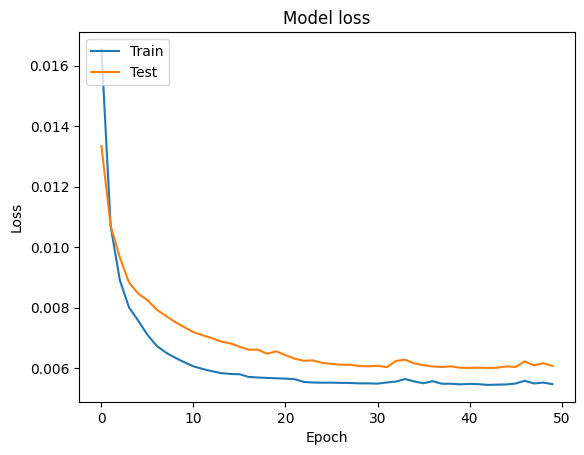

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()